In [1]:
import b3d
import jax.numpy as jnp
import os
from b3d import Mesh, Pose
import jax
import genjax
from genjax import Pytree
import rerun as rr
from b3d.modeling_utils import uniform_discrete, uniform_pose, gaussian_vmf
import matplotlib.pyplot as plt
from functools import partial
import importlib

In [170]:
b3d.rr_init("interactive")
key = jax.random.PRNGKey(0)
ycb_dir = os.path.join(b3d.get_assets_path(), "bop/ycbv")
scene_id = 49
image_id = 100

all_data = b3d.io.get_ycbv_test_images(ycb_dir, scene_id, [image_id, image_id+200])

meshes = [
    Mesh.from_obj_file(os.path.join(ycb_dir, f'models/obj_{f"{id + 1}".rjust(6, "0")}.ply')).scale(0.001)
    for id in all_data[0]["object_types"]
]

height, width = all_data[0]["rgbd"].shape[:2]
fx,fy,cx,cy = all_data[0]["camera_intrinsics"]
scaling_factor = 0.1
renderer = b3d.renderer.renderer_original.RendererOriginal(
    width * scaling_factor, height * scaling_factor, fx * scaling_factor, fy * scaling_factor, cx * scaling_factor, cy * scaling_factor, 0.01, 2.0
)
observed_rgbd_scaled_down = b3d.resize_image(all_data[0]["rgbd"], renderer.height, renderer.width)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  2.81it/s]


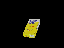

In [181]:
T = 0
initial_camera_pose = all_data[T]["camera_pose"]
initial_object_poses = all_data[T]["object_poses"]
IDX = 0
pose = initial_camera_pose.inv() @ initial_object_poses[IDX]
rendered_rgbd = renderer.render_rgbd_from_mesh(meshes[IDX].transform(pose))
b3d.viz_rgb(rendered_rgbd)

In [182]:
importlib.reload(b3d.colors)
def labd_to_rgbd(labd):
    return jnp.concatenate(
        [
            b3d.colors.lab_to_rgb(labd[..., :3]),
            labd[..., 3:4]
        ],
        axis=-1
    )

def rgbd_to_labd(rgbd):
    return jnp.concatenate(
        [
            b3d.colors.rgb_to_lab(rgbd[..., :3]),
            rgbd[..., 3:4]
        ],
        axis=-1
    )

In [183]:
@Pytree.dataclass
class MaskedKImageLikelihood(genjax.ExactDensity):
    def sample(self, key, row_coordinates, column_coordinates, variances, center_points, lower_bound, upper_bound, image_height, image_width):
        observed_image = jnp.zeros((image_height.const, image_width.const, 4))

        sampled_values = jax.vmap(genjax.truncated_normal.sample, in_axes=(0, 0, 0, None, None))(
            jax.random.split(key, len(row_coordinates)), center_points, variances,
            lower_bound, upper_bound
        )
        observed_image = observed_image.at[row_coordinates, column_coordinates, :].set(sampled_values)
        return observed_image

    def logpdf(self, observed_labd, row_coordinates, column_coordinates, variances, center_points, lower_bound, upper_bound, image_height, image_width):
        subset_observed_labd = observed_labd[row_coordinates, column_coordinates]
        scores = jax.vmap(genjax.truncated_normal.logpdf, in_axes=(0, 0, 0, None, None))(
            subset_observed_labd, center_points, variances,
            lower_bound, upper_bound
        )
        return scores.sum()

masked_k_image_likelihood = MaskedKImageLikelihood()

# k = 10
# masked_k_image_likelihood.logpdf(
#     jnp.zeros((renderer.height, renderer.width, 4)),
#     jnp.arange(k),
#     jnp.arange(k),
#     jnp.ones(k) * 0.1,
#     jnp.zeros(k),
#     jnp.zeros(4)- 0.1,
#     jnp.ones(4),
#     renderer.height,
#     renderer.width
# )
# masked_k_image_likelihood.sample(
#     key,
#     jnp.arange(k),
#     jnp.arange(k),
#     jnp.ones(k) * 0.1,
#     jnp.zeros(k),
#     jnp.zeros(4)- 0.1,
#     jnp.ones(4),
#     renderer.height,
#     renderer.width
# );

-270960.78


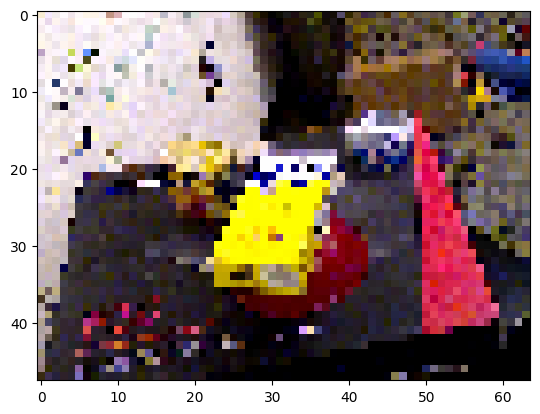

In [184]:
@genjax.gen
def ray_model(rendered_rgbd, likelihood_args):
    k = likelihood_args["k"].const
    image_height, image_width = likelihood_args["image_height"], likelihood_args["image_width"]

    row_coordinates = genjax.categorical.vmap(in_axes=(0,))(
            jnp.ones((k, image_height.const))
    )  @ "row_coordinates"
    column_coordinates = genjax.categorical.vmap(in_axes=(0,))(
            jnp.ones((k, image_width.const))
    ) @ "column_coordinates"

    rgb = rendered_rgbd[row_coordinates, column_coordinates, :3]
    lab = b3d.colors.rgb_to_lab(rgb)
    depth = rendered_rgbd[row_coordinates, column_coordinates, 3]

    outlier_probability = genjax.uniform(0.0, 1.0) @ "outlier_probability"
    inlier_color_variance = genjax.uniform(0.0001, 100.0) @ "inlier_color_variance"
    inlier_lightness_variance = genjax.uniform(0.0001, 100.0) @ "inlier_lightness_variance"
    inlier_depth_variance = genjax.uniform(0.0001, 10.0) @ "inlier_depth_variance"


    is_outlier = genjax.bernoulli.vmap(in_axes=(0,))(
        jnp.ones(k) * jax.scipy.special.logit(outlier_probability)
    )@ "is_outlier"

    no_mesh_surface = (depth == 0.0)

    is_outlier_adjusted = jnp.logical_or(is_outlier, no_mesh_surface)


    adjusted_lab_variance = (
        is_outlier_adjusted[..., None] * 1000000.0 +
        (1.0 - is_outlier_adjusted)[...,None] * jnp.ones((k,3)) * jnp.array([inlier_lightness_variance, inlier_color_variance, inlier_color_variance])
    )
    adjusted_depth_variance = is_outlier_adjusted * 1000000.0 + jnp.ones(k) * inlier_depth_variance
    variances = jnp.concatenate([adjusted_lab_variance, adjusted_depth_variance[:,None]], axis=-1)

    noiseless_labd = jnp.concatenate([lab, depth[:,None]], axis=-1)

    sampled_labd = masked_k_image_likelihood.sample(
        key,
        row_coordinates,
        column_coordinates,
        variances,
        noiseless_labd, jnp.array([0.0, -128.0, -128.0, 0.0]), jnp.array([100.0, 128.0, 128.0, 20.0]), image_height, image_width
    )

    observed_labd = masked_k_image_likelihood(
        row_coordinates,
        column_coordinates,
        variances,
        noiseless_labd, jnp.array([0.0, -128.0, -128.0, 0.0]), jnp.array([100.0, 128.0, 128.0, 20.0]), image_height, image_width
    ) @ "observed_labd"

    observed_rgbd = labd_to_rgbd(observed_labd)
    sampled_rgbd = labd_to_rgbd(sampled_labd)
    return {"sampled_rgbd": sampled_rgbd, "observed_rgbd": observed_rgbd}

    
@partial(jax.jit, static_argnums=(2,3,4))
def trace_from_parameters(
    key,
    rendered_rgbd,
    k,
    image_height,
    image_width,
    outlier_probability,
    inlier_lightness_variance,
    inlier_color_variance,
    inlier_depth_variance,
    observed_rgbd,
):
    key = jax.random.split(key, 2)[-1]
    
    likelikood_args = {
        "fx": fx,
        "fy": fy,
        "k": Pytree.const(k),
        "image_height": Pytree.const(image_height),
        "image_width": Pytree.const(image_width),
    }

    choicemap = genjax.ChoiceMap.d(
        {
            "outlier_probability": outlier_probability,
            "inlier_lightness_variance": inlier_lightness_variance,
            "inlier_color_variance": inlier_color_variance,
            "inlier_depth_variance": inlier_depth_variance,
            "observed_labd": rgbd_to_labd(observed_rgbd),
        }
    )

    trace = ray_model.importance(
        key, 
        choicemap,
        (rendered_rgbd, likelikood_args,),
    )[0]
    return trace, key
    
trace, key = trace_from_parameters(
    jax.random.PRNGKey(10),
    rendered_rgbd,
    10000,
    rendered_rgbd.shape[0], rendered_rgbd.shape[1],
    inlier_lightness_variance=10.0,
    inlier_color_variance=40.0,
    inlier_depth_variance=0.1,
    outlier_probability=0.1,
    observed_rgbd=observed_rgbd_scaled_down
)

choicemap = genjax.ChoiceMap.d(
    {
        "outlier_probability": 1.0,
        "inlier_lightness_variance": 1.0,
        "inlier_color_variance": 1.0,
        "inlier_depth_variance": 1.0,
    }
)
trace.update(
    key, 
    choicemap,
)
print(trace.get_score())

plt.imshow(trace.get_retval()["observed_rgbd"][..., :3])

In [185]:
from ipywidgets import interact
import ipywidgets as widgets

import matplotlib.pyplot as plt
import numpy as np


def plot(k,
    outlier_probability,
    inlier_lightness_variance,
    inlier_color_variance,
    inlier_depth_variance,):
    global key
    trace, key = trace_from_parameters(
        key,
        rendered_rgbd, k,
        rendered_rgbd.shape[0], rendered_rgbd.shape[1],
        outlier_probability,
        inlier_lightness_variance,
        inlier_color_variance,
        inlier_depth_variance,
        observed_rgbd_scaled_down
    )

    fig, ax = plt.subplots(1, 4, figsize=(10, 5))

    ax[0].imshow(rendered_rgbd[..., :3])
    ax[0].axis('off')

    ax[1].imshow(trace.get_retval()["sampled_rgbd"][..., :3])
    ax[1].axis('off')

    ax[2].matshow(trace.get_retval()["sampled_rgbd"][..., 3])
    ax[2].axis('off')


    ax[3].imshow(trace.get_retval()["observed_rgbd"][..., :3])
    ax[3].axis('off')

interact(plot,
    k = widgets.IntSlider(value=10000, min=1, max=100000, step=1),
    outlier_probability = widgets.FloatSlider(value=0.0, min=0.01, max=1.0, step=0.01),
    inlier_color_variance = widgets.FloatSlider(value=0.1, min=0.1, max=100.0, step=0.01),
    inlier_lightness_variance = widgets.FloatSlider(value=0.1, min=0.1, max=100.0, step=0.01),
    inlier_depth_variance = widgets.FloatSlider(value=0.0001, min=0.0001, max=100.0, step=0.01),
)

# Questions for vkm
# RGB is 3 channels. D is one. So doesn't RGB then get 3 times the influence as D
# The scales on L A B D are much different too.
# Outlier branch

interactive(children=(IntSlider(value=10000, description='k', max=100000, min=1), FloatSlider(value=0.01, desc…

<function __main__.plot(k, outlier_probability, inlier_lightness_variance, inlier_color_variance, inlier_depth_variance)>

In [186]:
def grid(
    trace,
    key,
    outlier_probability,
    inlier_lightness_variance,
    inlier_color_variance,
    inlier_depth_variance,
):
    choicemap = genjax.ChoiceMap.d(
        {
            "outlier_probability": outlier_probability,
            "inlier_lightness_variance": inlier_lightness_variance,
            "inlier_color_variance": inlier_color_variance,
            "inlier_depth_variance": inlier_depth_variance,
        }
    )
    return trace.update(
        key, 
        choicemap,
    )[0].get_score()
vmapped_grid = jax.jit(b3d.multivmap(grid, args=(False, False, True, True, True, True)))

In [188]:
outlier_probability_sweep = jnp.linspace(0.01, 1.0, 10)
inlier_lightness_variance_sweep = jnp.linspace(5.0, 100.0, 20)
inlier_color_variance_sweep = jnp.linspace(5.0, 100.0, 15)
inlier_depth_variance_sweep = jnp.linspace(0.01, 0.1, 12)

scores = vmapped_grid(
    trace,
    key,
    outlier_probability_sweep,
    inlier_lightness_variance_sweep,
    inlier_color_variance_sweep,
    inlier_depth_variance_sweep
)
print(scores.shape)
samples = jax.random.categorical(key, scores.reshape(-1),shape=(100,))
print(samples)
indices = jax.vmap(
    jnp.unravel_index,
    in_axes=(0,None)
)(samples, scores.shape)

sample_index=1
print(
    "Outlier Probability", outlier_probability_sweep[indices[0][sample_index]], "\n",
    "Inlier Lightness Variance", inlier_lightness_variance_sweep[indices[1][sample_index]], "\n",
    "Inlier Color Variance", inlier_color_variance_sweep[indices[2][sample_index]], "\n",
    "Inlier Depth Variance", inlier_depth_variance_sweep[indices[3][sample_index]], "\n",
)
interact(
    plot,
    k = widgets.IntSlider(value=10000, min=1, max=100000, step=1),
    outlier_probability = widgets.FloatSlider(value=outlier_probability_sweep[indices[0][sample_index]], min=0.01, max=1.0, step=0.01),
    inlier_lightness_variance = widgets.FloatSlider(value=inlier_lightness_variance_sweep[indices[1][sample_index]], min=0.1, max=100.0, step=0.01),
    inlier_color_variance = widgets.FloatSlider(value=inlier_color_variance_sweep[indices[2][sample_index]], min=0.1, max=100.0, step=0.01),
    inlier_depth_variance = widgets.FloatSlider(value=inlier_depth_variance_sweep[indices[3][sample_index]], min=0.0001, max=100.0, step=0.01),
)


(10, 20, 15, 12)
[5279 5279 5279 5459 5279 5279 5819 5459 5279 5459 5099 5279 5459 5279
 5279 5279 5459 5279 5279 5279 5279 5639 5279 5459 5279 5459 5279 5279
 5639 5279 5279 5279 5099 5459 5639 5099 5459 5459 5279 5099 5459 5099
 5459 5459 5279 5279 5279 5279 5279 5099 5279 5279 5279 5099 5279 5459
 5099 5279 5099 5099 5279 5279 5279 5279 5279 5279 5099 5459 5279 5459
 5279 5279 5459 5279 5279 5279 5279 5099 5279 5279 5279 5459 5279 5279
 5279 5279 5279 5279 5459 5279 5279 5279 5099 5459 5279 5459 5279 5279
 5459 5279]
Outlier Probability 0.120000005 
 Inlier Lightness Variance 50.0 
 Inlier Color Variance 32.14286 
 Inlier Depth Variance 0.1 



interactive(children=(IntSlider(value=10000, description='k', max=100000, min=1), FloatSlider(value=0.12000000…

<function __main__.plot(k, outlier_probability, inlier_lightness_variance, inlier_color_variance, inlier_depth_variance)>

In [ ]:
b3d.en

In [189]:
for sample_index in range(len(indices[0])):
    print(
        "Outlier Probability", outlier_probability_sweep[indices[0][sample_index]], "\n",
        "Inlier Lightness Variance", inlier_lightness_variance_sweep[indices[1][sample_index]], "\n",
        "Inlier Color Variance", inlier_color_variance_sweep[indices[2][sample_index]], "\n",
        "Inlier Depth Variance", inlier_depth_variance_sweep[indices[3][sample_index]], "\n",
    )

Outlier Probability 0.120000005 
 Inlier Lightness Variance 50.0 
 Inlier Color Variance 32.14286 
 Inlier Depth Variance 0.1 

Outlier Probability 0.120000005 
 Inlier Lightness Variance 50.0 
 Inlier Color Variance 32.14286 
 Inlier Depth Variance 0.1 

Outlier Probability 0.120000005 
 Inlier Lightness Variance 50.0 
 Inlier Color Variance 32.14286 
 Inlier Depth Variance 0.1 

Outlier Probability 0.120000005 
 Inlier Lightness Variance 54.999996 
 Inlier Color Variance 32.14286 
 Inlier Depth Variance 0.1 

Outlier Probability 0.120000005 
 Inlier Lightness Variance 50.0 
 Inlier Color Variance 32.14286 
 Inlier Depth Variance 0.1 

Outlier Probability 0.120000005 
 Inlier Lightness Variance 50.0 
 Inlier Color Variance 32.14286 
 Inlier Depth Variance 0.1 

Outlier Probability 0.120000005 
 Inlier Lightness Variance 65.0 
 Inlier Color Variance 32.14286 
 Inlier Depth Variance 0.1 

Outlier Probability 0.120000005 
 Inlier Lightness Variance 54.999996 
 Inlier Color Variance 32.14

In [160]:
# Matched
Outlier Probability 0.120000005 
 Inlier Lightness Variance 50.0 
 Inlier Color Variance 32.14286 
 Inlier Depth Variance 0.1 

# Mismatched
Outlier Probability 0.120000005 
 Inlier Lightness Variance 100.0 
 Inlier Color Variance 52.500004 
 Inlier Depth Variance 0.1 

Array([1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949,
       1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949,
       1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949,
       1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949,
       1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949,
       1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949,
       1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949,
       1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949,
       1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949,
       1949], dtype=int32)

In [41]:
trace.get_choices()["noisy_lab_color",...].shape

(10000, 3)